In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point
import adjustText as aT

import plotly.express as px

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

import os
from pathlib import Path

from tqdm.auto import tqdm

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

## Load data

In [2]:
hsda_shape = gpd.read_file("data/shape_files/hsda_2018/HSDA_2018.shp")
hsda_shape["center"] = hsda_shape["geometry"].centroid
hsda_shape["rep"] = hsda_shape["geometry"].representative_point()
hsda_shape.head()

HSDA_CD HSDA_ID                 HSDA_Name                   HSDA_Title  \
0      11   11 EK             East Kootenay             11 East Kootenay   
1      12   12 KB         Kootenay Boundary         12 Kootenay Boundary   
2      13   13 OK                  Okanagan                  13 Okanagan   
3      14   14 TC  Thompson Cariboo Shuswap  14 Thompson Cariboo Shuswap   
4      21   21 FE               Fraser East               21 Fraser East   

  HA_CD  HA_ID   HA_Name    HA_Title  HSDA_Pop16  HSDA_Area   Latitude  \
0     1  1 IHA  Interior  1 Interior       79929   44984.70  50.394356   
1     1  1 IHA  Interior  1 Interior       78390   28857.67  49.825113   
2     1  1 IHA  Interior  1 Interior      362258   21414.90  49.924608   
3     1  1 IHA  Interior  1 Interior      219412  120156.18  51.511357   
4     2  2 FHA    Fraser    2 Fraser      295844   12579.33  49.532357   

    Longitude                                           geometry  \
0 -116.194708  POLYGON ((1542406.035 861035.914, 1542488.489 ...   
1 -117.779323  POLYGON ((1614083.479 709557.515, 1614438.266 ...   
2 -119.505626  POLYGON ((1523512.992 685256.813, 1523632.014 ...   
3 -121.387149  POLYGON ((1371176.710 901822.639, 1371321.497 ...   
4 -121.818459  POLYGON ((1238874.902 575932.353, 1238850.391 ...   

                           center                             rep  
0  POINT (1694732.693 645759.290)  POINT (1705050.235 673966.930)  
1  POINT (1590317.476 568647.599)  POINT (1607566.926 587881.015)  
2  POINT (1462965.927 555657.856)  POINT (1495061.721 571001.293)  
3  POINT (1319531.448 732461.085)  POINT (1323934.150 712174.659)  
4  POINT (1302638.827 510657.163)  POINT (1304843.094 512674.801)

In [3]:
# BC Population by Health Regions
# Source: https://catalogue.data.gov.bc.ca/dataset/community-health-service-areas-chsa/resource/ff7ea5dd-d489-4f74-a97e-3c57661ce830
bc_health_region_master = pd.read_excel("data/bc_health_region_master_2018.xlsx")
hsda_pop_2016 = bc_health_region_master.groupby("HSDA_Name")["CHSA_Pop2016"].sum()
ha_pop_2016 = bc_health_region_master.groupby("HA_Name")["CHSA_Pop2016"].sum()

In [4]:
# Cases by Health Area
# Source: BC CDC
cases_url = "http://www.bccdc.ca/Health-Info-Site/Documents/BCCDC_COVID19_Dashboard_Case_Details.csv"
cases_ha = pd.read_csv(cases_url, parse_dates=["Reported_Date"])

In [5]:
# Cumulative cases per week by Health Service Delivery Area
# This data has been manually curated (and shared openly) by Tyler Olsen and Jens von Bergmann
# Source: https://twitter.com/ty_olsen/status/1327036143519502336
# CBC Page to parse data: http://www.bccdc.ca/health-info/diseases-conditions/covid-19/data

cases_hsda_url = "https://docs.google.com/spreadsheets/d/1qyEaS27u51B3A_NWHN22ULnj9odLT1A6K__tro5UY5w/export?format=csv&gid=1688823368"

cases_hsda_url = "https://docs.google.com/spreadsheets/d/1oLQtwrk5q-fvi6p4d2ZTWS8_eiatQ4zgaZQ396mwBUM/export?format=csv"
cases_hsda = pd.read_csv(cases_hsda_url)
cases_hsda = cases_hsda.iloc[0:16]
cases_hsda = cases_hsda.set_index("Region").astype(int)

cases_hsda = cases_hsda.rename({'North Shore - Coast Garibaldi': 'North Shore/Coast Garibaldi'})
cases_hsda.head()

Jul 9  Jul 16  Jul 23  Jul 30  Aug 6  Aug 13  \
Region                                                                   
Northwest                    14      14      25      34     41      42   
Northeast                    15      15      16      16     16      28   
Northern Interior            36      36      36      36     36      36   
Central Vancouver Island     26      28      33      34     37      39   
South Vancouver Island       48      49      50      50     50      51   

                          Aug 20  Aug 27  Sep 3  Sep 10  ...  Sep 24  Oct 1  \
Region                                                   ...                  
Northwest                     42      46     50      54  ...      68     79   
Northeast                     42      50     74      99  ...     121    134   
Northern Interior             37      41     43      50  ...      89    104   
Central Vancouver Island      41      46     49      51  ...      59     61   
South Vancouver Island        58      65     65      71  ...      76     79   

                          Oct 8  Oct 15  Oct 22  Oct 29  Nov 5  Nov 12  \
Region                                                                   
Northwest                    81      85      92     103    104     108   
Northeast                   137     140     150     165    175     201   
Northern Interior           112     120     123     138    159     188   
Central Vancouver Island     67      75      78      81     88     103   
South Vancouver Island       85      91      95      97    107     126   

                          Nov 19  Nov 26  
Region                                    
Northwest                    121     157  
Northeast                    216     262  
Northern Interior            223     346  
Central Vancouver Island     174     256  
South Vancouver Island       146     183  

[5 rows x 21 columns]

In [6]:
# New cases per week
new_cases_hsda = cases_hsda.copy()
columns = new_cases_hsda.columns

for i in range(1, len(columns)):
    new_cases_hsda[columns[i]] = cases_hsda[columns[i]] - cases_hsda[columns[i-1]]
del new_cases_hsda[columns[0]]
new_cases_hsda.head()

Jul 16  Jul 23  Jul 30  Aug 6  Aug 13  Aug 20  \
Region                                                                    
Northwest                      0      11       9      7       1       0   
Northeast                      0       1       0      0      12      14   
Northern Interior              0       0       0      0       0       1   
Central Vancouver Island       2       5       1      3       2       2   
South Vancouver Island         1       1       0      0       1       7   

                          Aug 27  Sep 3  Sep 10  Sep 17  Sep 24  Oct 1  Oct 8  \
Region                                                                          
Northwest                      4      4       4       2      12     11      2   
Northeast                      8     24      25      17       5     13      3   
Northern Interior              4      2       7      19      20     15      8   
Central Vancouver Island       5      3       2       4       4      2      6   
South Vancouver Island         7      0       6       5       0      3      6   

                          Oct 15  Oct 22  Oct 29  Nov 5  Nov 12  Nov 19  \
Region                                                                    
Northwest                      4       7      11      1       4      13   
Northeast                      3      10      15     10      26      15   
Northern Interior              8       3      15     21      29      35   
Central Vancouver Island       8       3       3      7      15      71   
South Vancouver Island         6       4       2     10      19      20   

                          Nov 26  
Region                            
Northwest                     36  
Northeast                     46  
Northern Interior            123  
Central Vancouver Island      82  
South Vancouver Island        37

## Rolling average of new cases (window=7 days) by HA

In [7]:
new_cases_ha = cases_ha.groupby(["HA", "Reported_Date"]).size().to_frame("Cases").reset_index()

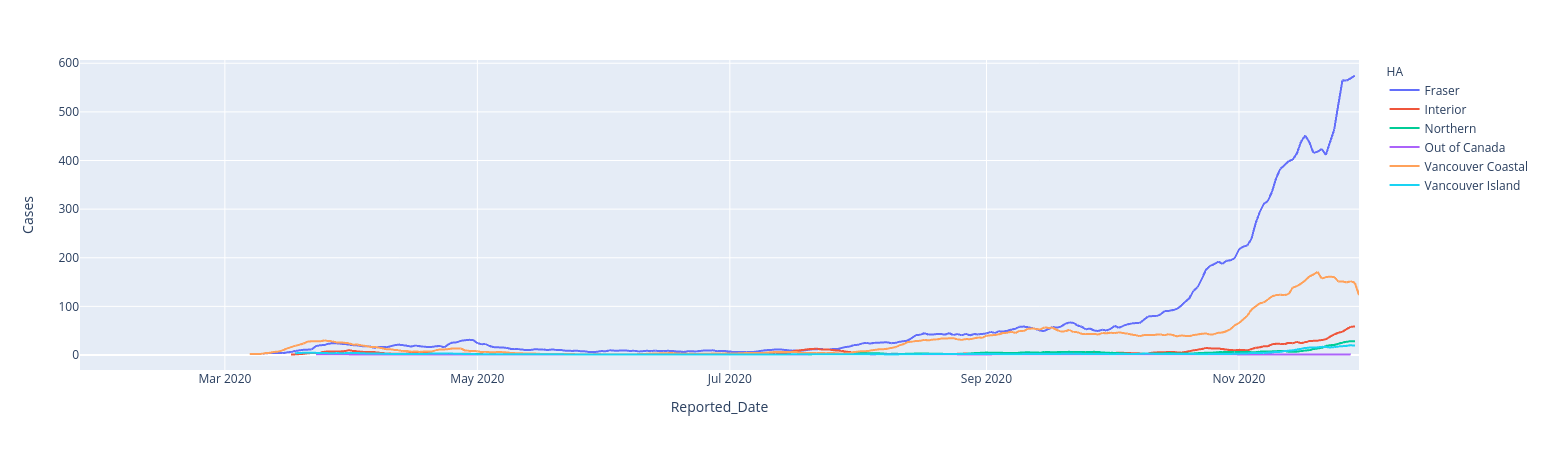

In [8]:
pdf = new_cases_ha.set_index("Reported_Date").groupby("HA").rolling(window=7).mean().reset_index()
px.line(pdf, x="Reported_Date", y="Cases", color="HA")

## Rolling average of new cases (days=7) by HA per 100,000 inhabitants

In [84]:
import numpy as np

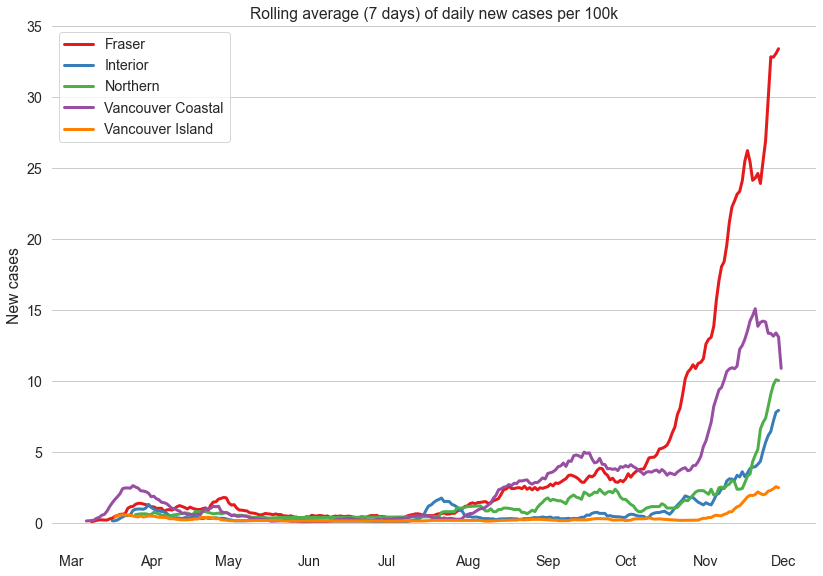

In [98]:
pdf = new_cases_ha[new_cases_ha.HA!="Out of Canada"]
pdf = pdf.rename(columns={"Reported_Date": "Date", "HA": "Health Authority"})
# pdf["Date"] = pdf["Date"].dt.strftime("%y %b")
pdf = pdf.set_index("Date").groupby("Health Authority").rolling(window=7).mean().reset_index().dropna()
pdf["New cases"] = pdf.set_index("Health Authority")["Cases"].div(ha_pop_2016/100000).values

# palette = sns.color_palette("Set2", 16)

sns.set(font_scale=1.3)
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(x="Date", y="New cases", hue="Health Authority", data=pdf, palette="Set1", markers=True, linewidth=3, )
    sns.despine(left=True, right=True, top=True, bottom=True)
#     plt.xticks(rotation=45)
    plt.grid(axis="x")
    plt.title("Rolling average (7 days) of daily new cases per 100k")
    plt.xlabel("")
    
    leg = plt.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    fig.autofmt_xdate()
    
    plt.tight_layout()

## New cases by HSDA

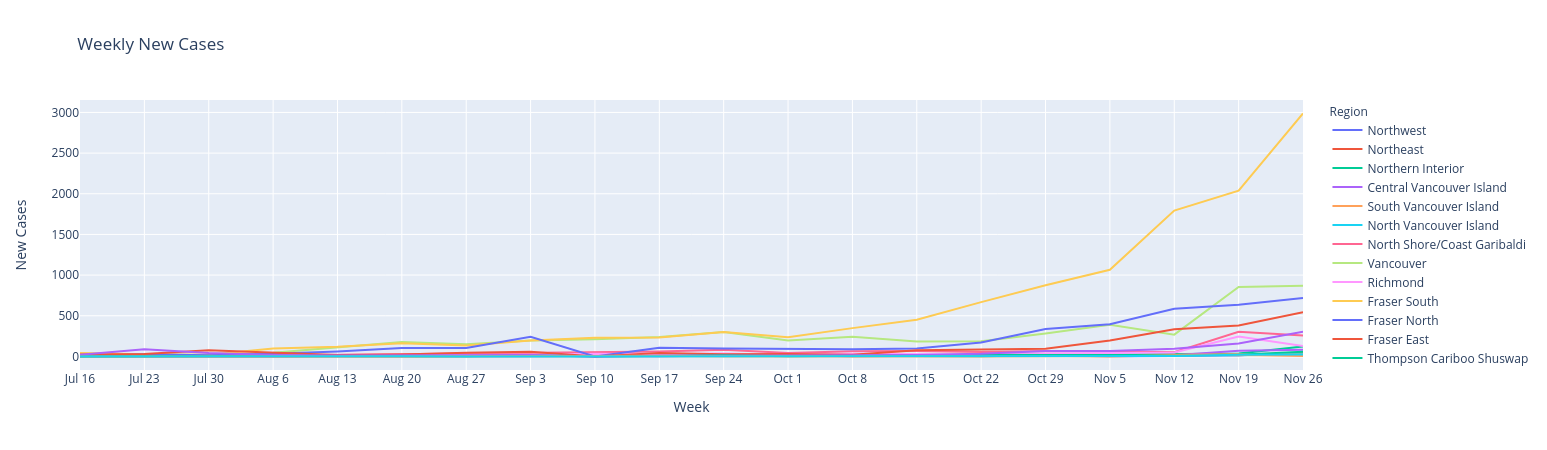

In [10]:
pdf = new_cases_hsda.reset_index().melt(id_vars="Region", var_name="Week", value_name="New Cases")
px.line(pdf, x="Week", y="New Cases", color="Region", title='Weekly New Cases')

In [11]:
cases_ha

Reported_Date                 HA Sex Age_Group Classification_Reported
0        2020-01-26      Out of Canada   M     40-49           Lab-diagnosed
1        2020-02-02  Vancouver Coastal   F     50-59           Lab-diagnosed
2        2020-02-05      Out of Canada   F     20-29           Lab-diagnosed
3        2020-02-05      Out of Canada   M     30-39           Lab-diagnosed
4        2020-02-11           Interior   F     30-39           Lab-diagnosed
...             ...                ...  ..       ...                     ...
33233    2020-11-29  Vancouver Coastal   F     60-69           Lab-diagnosed
33234    2020-11-30  Vancouver Coastal   M     10-19           Lab-diagnosed
33235    2020-11-30  Vancouver Coastal   M     20-29           Lab-diagnosed
33236    2020-11-30  Vancouver Coastal   M     30-39           Lab-diagnosed
33237    2020-11-30  Vancouver Coastal   M     30-39           Lab-diagnosed

[33238 rows x 5 columns]

## New cases by HSDA per 100,000 inhabitants

In [49]:
# Normalize for population

new_per_10000 = (100000*new_cases_hsda).div(hsda_pop_2016, axis=0).astype(int)
new_per_10000.columns = pd.to_datetime(new_per_10000.T.index, format="%b %d").strftime("%b %d").tolist()
new_per_10000.index.name = "HSDA"

new_per_10000.style.background_gradient(cmap ='OrRd', axis=None, vmax=300)

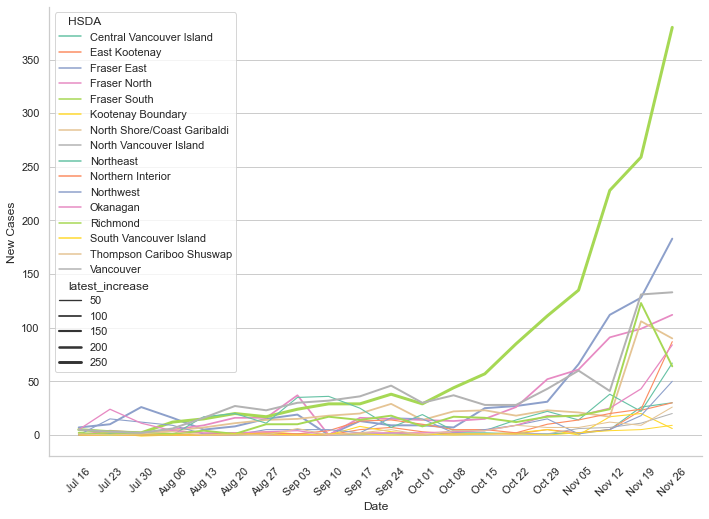

In [52]:
pdf = new_per_10000.reset_index().melt(id_vars="HSDA", var_name="Date", value_name="New Cases")
pdf = pdf.set_index("HSDA")
pdf["latest_increase"] = new_per_10000["Nov 19"]

palette = sns.color_palette("Set2", 16)

with sns.axes_style("whitegrid"):
    sns.lineplot(x="Date", y="New Cases", hue="HSDA", data=pdf, size="latest_increase", sizes=(1, 3), palette=palette, markers=True)
    sns.despine()
    plt.xticks(rotation=45)
    plt.grid(axis="x")

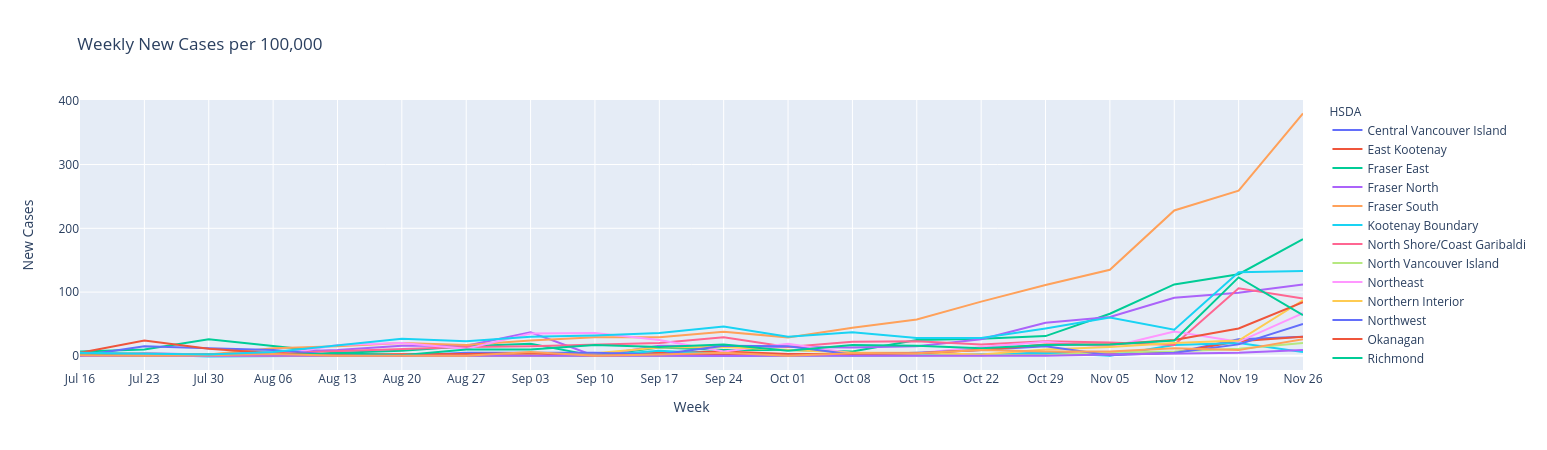

In [16]:
pdf = new_per_10000.reset_index().melt(id_vars="HSDA", var_name="Week", value_name="New Cases")
px.line(pdf, x="Week", y="New Cases", color="HSDA", title='Weekly New Cases per 100,000')

## Animated Maps

In [21]:
zoomed = ["Vancouver",
          "Richmond",
          "Surrey",
          "Fraser North",
          "Fraser South",
         # "Fraser East"
            ]

dpi = 300
figsize = (10,8)

today = '2020-11-26'

# save all the maps in the charts folder
output_path = Path(f'outputs/{today}')
if not output_path.exists():
    output_path.mkdir()

map_content = new_per_10000

colormap = 'Blues'
colormap = 'OrRd'

In [22]:
vmin, vmax = 0, new_per_10000.max().max()
weeks = new_per_10000.columns.tolist()

# Shape Variables
bc = hsda_shape.merge(map_content, left_on="HSDA_Name", right_index=True)
bc_zoomed = bc[bc.HSDA_Name.isin(zoomed)]

# Annotations
bc_za_points = bc[~bc.HSDA_Name.isin(zoomed)].copy()
bc_za_points.set_geometry("rep", inplace = True)

bczoomed_za_points = bc_zoomed.copy()
bczoomed_za_points.set_geometry("rep", inplace = True)

# sub region of the original image
x1 = bc_zoomed.bounds.minx.min()
x2 = bc_zoomed.bounds.maxx.max()
y1 = bc_zoomed.bounds.miny.min()
y2 = bc_zoomed.bounds.maxy.max()

In [23]:
pdf = cases_ha.groupby(["HA", pd.Grouper(key='Reported_Date', freq='W-THU')]).size().to_frame("Cases").reset_index()
pdf = pdf.set_index("Reported_Date").loc['2020-07-16':today.replace("-", "")].reset_index()
pdf['Date'] = pdf["Reported_Date"].dt.strftime("%b %d")
pdf = pdf[["Date", "HA", "Cases"]].pivot(index="Date", columns="HA", values="Cases").reset_index().set_index("Date")

pdf = pdf.div((ha_pop_2016/100000)).drop(columns="Out of Canada").astype(int)

date_list = pdf.index.unique().tolist()

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

<Figure size 720x576 with 0 Axes>

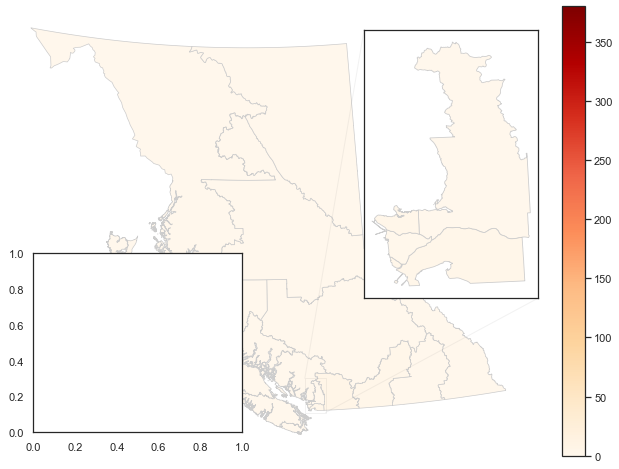

In [53]:
for i, week in enumerate(tqdm(weeks)):
    #####################
    # Create Bigger Map #
    #####################
    fig = plt.figure(figsize=figsize);
    ax = bc.plot(column=week, cmap=colormap, linewidth=0.7, edgecolor='0.8', vmin=vmin, vmax=vmax, legend=True);
    ax.axis('off');

    #####################
    # Create Zoomed Map #
    #####################
    subax = ax.inset_axes([0.6, 0.35, 0.5, 0.6])
    bc_zoomed.plot(column=week, cmap=colormap, linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax, ax=subax);
    
    subax.set(yticklabels=[], xticklabels=[]);
    ax.indicate_inset_zoom(subax, alpha=.1);
    
    ##############
    # Totals Bar #
    ##############
    subax2 = ax.inset_axes([.05, .05, 0.4, 0.4])
    subax2.set_xlim(0, pdf.max().max())
    sns.despine(ax=subax2)
    subax2.patch.set_alpha(0)

    pdf.loc[week].to_frame("Cases").plot(kind="barh", color="#fdbb84", ax=subax2, legend=False)
    subax2.set_ylabel("")
#     subax2.set_xlabel("Weekly New Cases per 100k")
    
    #######################
    # Title & Annotations #
    #######################
    plt.title('Weekly New Cases per 100k',
              fontdict={'fontsize': '25', 'fontweight' : '3'});
    
    # Week labels
    ax.annotate(f"Week {28+i}: {week}",
            xy=(0.74, .04), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=20);
    
    # Credit
    ax.annotate("Created by: Asura Enkhbayar (@bubblbu_)",
            xy=(0.63, 0), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=12, color="gray");
    
    # HSDA Labels
    for a, za_points in zip([ax, subax], [bc_za_points, bczoomed_za_points]):
        texts = []

        for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["HSDA_Name"]):
            texts.append(a.text(x, y, label, fontsize = 10, alpha=.7, ha='center'))

        aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), autoalign="y",
                            arrowprops=dict(arrowstyle="-", color='grey', lw=0))
    
    # Adjust space before adding progress bar.
    plt.tight_layout();
    fig.subplots_adjust(bottom=0, hspace=0, wspace=0)
    
    # Progress bar    
    w = figsize[0]*dpi
    line = Rectangle((0, 0), w/len(weeks)*i, 20,
                     facecolor='lightgray',
                     fill=True, transform=None)
    line.set_clip_on(False)
    ax.add_patch(line)
    
    ##############
    # Save files #
    ##############
    outfile = output_path / f'{i:02}_bc_cases.png'
    plt.savefig(outfile , dpi=dpi, bbox_inches="tight", pad_inches=0);
    plt.close();

### Playground

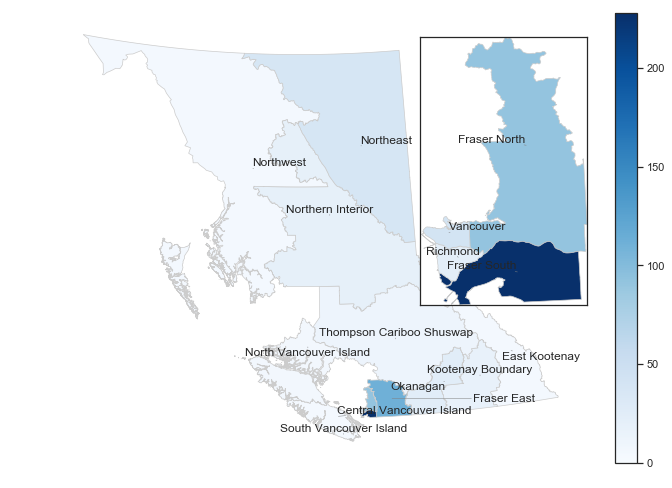

In [49]:
figsize = (10,8)

ax = bc.plot(column=week, cmap='Blues', linewidth=0.7, edgecolor='0.8', legend=True, vmin=vmin, vmax=vmax);

# remove axis of chart
ax.axis('off');

subax = ax.inset_axes([0.6, 0.35, 0.5, 0.6])

fig_zoomed = bc_zoomed.plot(column=week, cmap='Blues', linewidth=0.7, edgecolor='0.8', vmin=vmin, vmax=vmax, ax=subax);
subax.set(yticklabels=[], xticklabels=[]);

# sub region of the original image
x1 = bc_zoomed.bounds.minx.min()
x2 = bc_zoomed.bounds.maxx.max()
y1 = bc_zoomed.bounds.miny.min()
y2 = bc_zoomed.bounds.maxy.max()

subax.set_xlim(x1, x2)
subax.set_ylim(y1, y2)

for a, za_points in zip([ax, subax], [bc_za_points, bczoomed_za_points]):
    texts = []

    for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["HSDA_Name"]):
        texts.append(a.text(x, y, label, fontsize = 12))

    aT.adjust_text(texts, autoalign="y",
                   arrowprops=dict(arrowstyle="-", color='grey', lw=0.5),
                   ax=a)